# Bayesian Regression using Metropolis Hastings

Let $Y$ be a response and $X$ be predictors. In a linear model we assume that the response given the predictor is normally distributed, that is:

\begin{equation}
    Y|X \sim \mathcal{N}(aX + b, \sigma^2)
\end{equation}

where $a$ is the slope, $b$ is the intercept (bias) and $\sigma^2$ is the variance. We wish to infer all of these quantities based on data.

We will generate synthetic data where $a=3$, $b=5$ and $\sigma=3$

Text(0, 0.5, 'y')

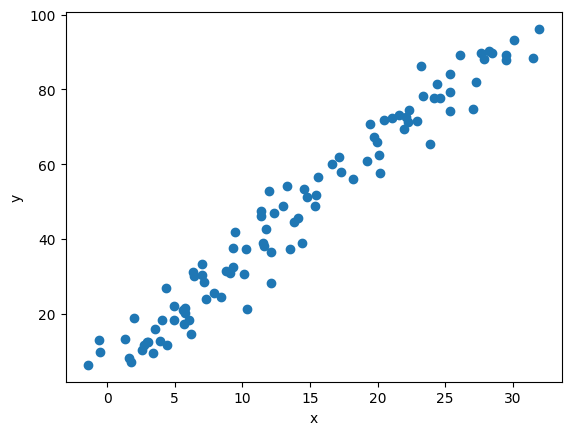

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc

# sample x
np.random.seed(42)
x = np.random.rand(100)*30

# set parameters
a = 3
b = 5
sigma = 3


# obtain response and add noise
y = a*x+b
noise = np.random.randn(100)*sigma

# create a matrix containing the predictor in the first column
# and the response in the second
data = np.vstack((x,y)).T + noise.reshape(-1,1)

# plot data 
plt.scatter(data[:,0], data[:,1])
plt.xlabel("x")
plt.ylabel("y")

Let $\theta=[a,b,\sigma]$ be a vector of our parameters. Let $\theta'$ be a new proposal for our parameters. The Metropolis-Hastings algorithm compares the Bayes' Factor (product of likelihood and prior) between two hypothesese for parameters ($\theta$, $\theta'$) and scales this factor by the reciprocal of the conditional proposal distribution. This is compared to a uniformly distributed random variable.

## The proposal distribution
We need to define $g(\theta'|\theta)$. As $a,b$ can be positive or negative real numbers, we will set a prior using the multivariate normal distribtion, centered at the previous iteration step. As sigma can only be positive, we will use a Gamma distribution. 

So we can define our proposal distributions in the following way:

\begin{equation}
    \begin{pmatrix} 
        a' \\ 
        b' 
    \end{pmatrix} 
    \sim 
    N \left( 
    \begin{pmatrix} 
        a \\ 
        b 
    \end{pmatrix}, 
    \begin{pmatrix} 
        k^2 & 0 \\ 
        0 & k^2 
    \end{pmatrix} 
    \right)
\end{equation}

and

\begin{equation}
    \sigma' \sim \Gamma(\sigma k w, k w)
\end{equation}

Where the parameter $k$ is the standard deviation of the proposal distribution and $w$ is a scaling factor for the gamma distribution specifically

In [2]:
def proposal(prec_theta, search_width = 0.5):
    # this function generates a new proposal for the parameters
    # where the prior is normal for a,b and gamma for sigma
    # conditional on prec_theta (the previous proposal)
    theta_new = np.zeros(3)
    theta_new[:2] = sc.multivariate_normal(mean = prec_theta[:2], cov = np.eye(2)*search_width**2).rvs(1)
    theta_new[2] = sc.gamma(a = prec_theta[2]*search_width*500, scale = 1/(search_width*500)).rvs()
    return theta_new


## The Likelihood
We derive the likelihood from the choice of linear model. The conditional distribution of the response given the parameters is normally distribution. We will use log likelihood for stability.

In [3]:
def lhd(x, theta):
    # x is the data matrix
    # theta is a vector of parameters
    xs = x[:,0]
    ys = x[:,1]
    lhd_out = sc.norm.logpdf(ys, loc=theta[0]*xs+theta[1], scale=theta[2])
    # we sum lhd_out as we are using log likelihoods
    lhd_out = np.sum(lhd_out)
    return lhd_out

## The Prior
We can choose anything we like for the prior. We will use a normal distribution for $a$ and $b$ and a gamma distribution for $\sigma$.


In [4]:
def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:2],mean=np.array([0,0]), cov=np.eye(2)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[2], a=1, scale=1)
    return prior_out

# The Proposal Ratio

The proposal ratio is the ratio of the proposal distribution at $\theta'$ to the proposal distribution at $\theta$, that is $g(\theta|\theta')/g(\theta'|\theta)$. This is used to scale the Bayes' Factor. We will use log-pdf for numerical stability.

In [5]:
def proposal_ratio(theta_old, theta_new, search_width = 10):
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[2], a=theta_new[2]*search_width*500, scale=1/(500*search_width))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[2], a=theta_old[2]*search_width*500, scale=1/(500*search_width))
    return prop_ratio_out

## The Metropolis-Hastings Algorithm

The pseudocode for the Metropolis-Hastings algorithm is as follows:
1) Instantiate initial values for the parameter vector 

... N TIMES or UNTIL CONVERGENCE

2) Draw a new parameter vector from the proposal

3) Calculate likelihood, prior pdf value and the reciprocal of the proposal likelihood ratio

4) Multiply all the quantities in 3 (or sum if in log) and compare this ratio (in linear scale) against a number drawn from a uniform distribution.

5) If the ratio is larger, the new parameter vector is accepted. Otherwise, the new parameter vector is rejected.
     
6) Move to 2)

In [6]:
np.random.seed(42)

width = 0.2

thetas = np.random.rand(3).reshape(1,-1)

accepted = 0
rejected = 0

N = 20000

for i in range(N):
    # provide the proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)

    # calculate the likelihood of the proposal and the likelihood of the previous theta
    log_lik_theta_new = lhd(data, theta_new)
    log_lik_theta = lhd(data, thetas[-1,:])

    # calculate the prior of the proposal and the prior of the previous theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])

    # calculate the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1,:], theta_new, search_width=width)

    # assemble the likelihoods, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + theta_new_prior - theta_prior + prop_ratio

    #

    if np.exp(likelihood_prior_proposal_ratio) > sc.uniform.rvs():
        thetas = np.vstack((thetas, theta_new))
        accepted += 1
    else:
        thetas = np.vstack((thetas, thetas[-1,:]))
        rejected += 1

print("DONE! Acceptance rate: ", accepted/N)

C:\Users\s1723280\AppData\Local\Temp\ipykernel_27080\3507240717.py:32: RuntimeWarning: overflow encountered in exp
  if np.exp(likelihood_prior_proposal_ratio) > sc.uniform.rvs():


DONE! Acceptance rate:  0.17395


Let's check our sampling. In particular we want to check that the M-H algorithm has converged. We also need to establish a suitable burn in

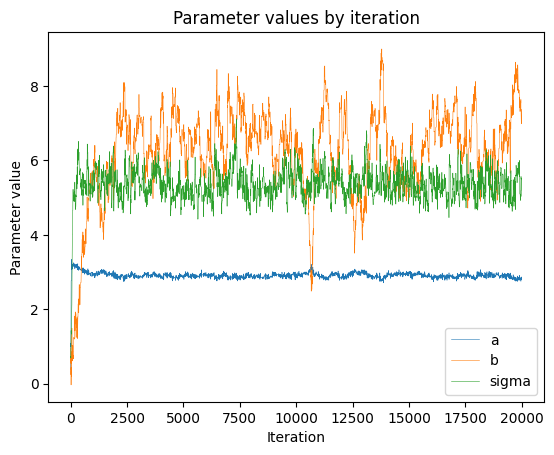

In [7]:
# Plot parameter values by iterations
plt.plot(thetas[:,0], label="a", linewidth=0.4)
plt.plot(thetas[:,1], label="b", linewidth=0.4)
plt.plot(thetas[:,2], label="sigma", linewidth=0.4)
plt.xlabel("Iteration")
plt.ylabel("Parameter value")
plt.title("Parameter values by iteration")
plt.legend()
plt.show()

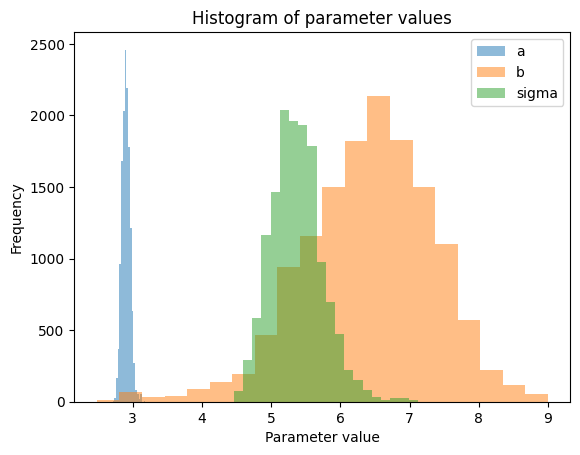

In [8]:
# Make histograms of the parameter values
burn_in = 6000
plt.hist(thetas[burn_in:,0], bins=20, alpha=0.5, label="a")
plt.hist(thetas[burn_in:,1], bins=20, alpha=0.5, label="b")
plt.hist(thetas[burn_in:,2], bins=20, alpha=0.5, label="sigma")
plt.xlabel("Parameter value")
plt.ylabel("Frequency")
plt.title("Histogram of parameter values")
plt.legend()
plt.show()


In [9]:
# Make a table showing the mean and standard deviation of the parameter values, after discarding the first 1000 samples
print("Mean and standard deviation of parameter values after burn-in:")
print("a: ", np.mean(thetas[burn_in:,0]), np.std(thetas[burn_in:,0]))
print("b: ", np.mean(thetas[burn_in:,1]), np.std(thetas[burn_in:,1]))
print("sigma: ", np.mean(thetas[burn_in:,2]), np.std(thetas[burn_in:,2]))


Mean and standard deviation of parameter values after burn-in:
a:  2.9027025058531057 0.058032548937420034
b:  6.410669128462907 0.942190117152812
sigma:  5.371316920260681 0.36903182368100196


## Compare with traditional (frequentist) linear regression

In [10]:
import statsmodels.api as sm
import pandas as pd

df = pd.DataFrame(data)
df.columns = ["a","y"]
df["b"] = 1
lm = sm.OLS(df["y"], df[["a","b"]]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     2254.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           1.92e-69
Time:                        14:52:21   Log-Likelihood:                -310.21
No. Observations:                 100   AIC:                             624.4
Df Residuals:                      98   BIC:                             629.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              2.9038      0.061     47.477      0.000       2.782       3.025
b              6.3628      1.020      6.240      0.000       4.339       8.386
==============================================================================
Omnibus:                        1.076   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                1.008
Skew:                          -0.241   Prob(JB):                        0.604
Kurtosis:                       2.898   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""